# Dual-tone multi-frequency (DTMF) signaling

DTMF signaling is the way analog phones send the number dialed by a user over to the central phone office. This was in the day before all-digital networks and cell phones were the norm, but the method is still used for in-call option selection ("press 4 to talk to customer service"...).

The mechanism is rather clever: the phone's keypad is arranged in a $4\times 3$ grid and each button is associated to *two* frequencies according to this table:


|            | **1209 Hz** | **1336 Hz** | **1477 Hz** |
|------------|:-----------:|:-----------:|:-----------:|
| **697 Hz** |      1      |      2      |      3      |
| **770 Hz** |      4      |      5      |      6      |
| **852 Hz** |      7      |      8      |      9      |
| **941 Hz** |      *      |      0      |      #      |


The  frequencies in the table have been chosen so that they are "coprime"; in other words, no frequency is a multiple of any other, which reduces the probability of erroneously detecting the received signals due to interference. When a button is pressed, the two corresponding frequencies are generated simultaneously and sent over the line. For instance, if the digit '1' is pressed, the generated signal will be:

$$
    x(t) = \sin(2\pi\cdot 1209\cdot t) + \sin(2\pi\cdot697\cdot t)
$$


The official specifications for the DTMF standard further stipulate that:

 * each tone should be at least 65ms long
 * tones corresponding to successive digits should be separated by a silent gap of at least 65ms


In this notebook we will build a DTMF decoder based on the Discrete Fourier Transform. 
Of course here we will use discrete-time signals exclusively so, if the clock of the system is $F_s$, each DTMF tone will be of the form:
$$
    x[n] = \sin(2\pi\,(f_l/F_s)\, n) + \sin(2\pi\,(f_h/F_s)\,n)
$$

The first thing to do is to write a DTMF encoder.

In [6]:
# first our usual bookkeeping
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython

In [7]:
plt.rcParams["figure.figsize"] = (14,4)

In [8]:
# the "clock" of the system
FS = 24000

In [9]:
def dtmf_dial(number):
    DTMF = {
        '1': (697, 1209), '2': (697, 1336), '3': (697, 1477),
        '4': (770, 1209), '5': (770, 1336), '6': (770, 1477),
        '7': (852, 1209), '8': (852, 1336), '9': (852, 1477),
        '*': (941, 1209), '0': (941, 1336), '#': (941, 1477),        
    }
    MARK = 0.1
    SPACE = 0.1
    n = np.arange(0, int(MARK * FS))
    x = np.array([])
    for d in number:
        s = np.sin(2*np.pi * DTMF[d][0] / FS * n) + np.sin(2*np.pi * DTMF[d][1] / FS * n) 
        x = np.concatenate((x, s, np.zeros(int(SPACE * FS))))
    return x

OK, that was easy. Let's test it and evaluate it "by ear":

In [10]:
x=dtmf_dial('123##45')

IPython.display.Audio(x, rate=FS)

Now let's start thinking about the decoder. We will use the following strategy:

 * split the signal into individual digit tones by looking at the position of the gaps
 * perform a DFT on the digit tones
 * look at the peaks of the Fourier transform and recover the dialed number
 
Here we assume whe have the whole signal in memory, i.e. we will perform *batch* processing; clearly a more practical system would decode the incoming signal as it arrives sample by sample (real-time processing) and, indeed, this will be the subject of a future notebook.

To split the signal the idea is to look at the local energy over small windows: when the signal is silence, we will cut it.

Let's see how we can do that; let's look at the raw data first

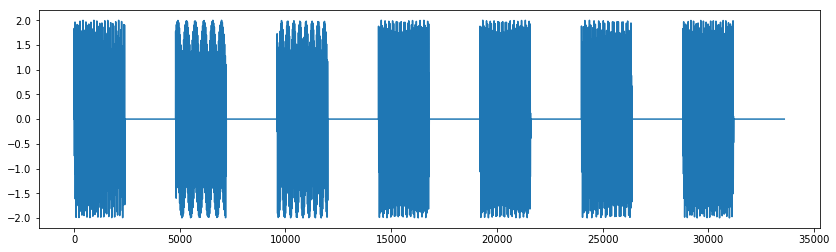

In [11]:
plt.plot(x);

OK so, clearly, we should be able to find the high and low energy sections of the signal. Let's say that we use an analysis window of 240 samples which, at our $F_s$ corresponds to an interval of 10ms. We can easily find the local energy like so:

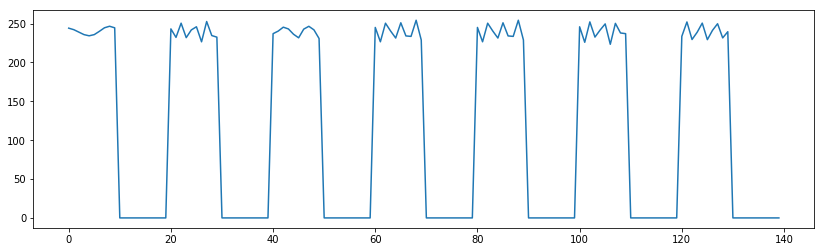

In [33]:
# split the signal in 240-sample chunks and arrange them as rows in a matrix
# (truncate the data vector to a length multiple of 240 to avoid errors)
w = np.reshape(x[:int(len(x)/240)*240], (-1, 240))

# compute the energy of each chunk by summing the squares of the elements of each row
we = np.sum(w * w, axis=1)

plt.plot(we);

From the plot, it appears clearly that we can set a threshold of about 200 to separate tone sections from silence sections. Let's write a function that returns the start and stop indices of the tone sections in an input signal

In [13]:
def dtmf_split(x, win=240, th=200):
    edges = []
    
    w = np.reshape(x[:int(len(x)/win)*win], (-1, win))
    we = np.sum(w * w, axis=1)
    L = len(we)
    
    ix = 0
    while ix < L:
        while ix < L and we[ix] < th:
            ix = ix+1
        if ix >= L:
            break    # ending on silence
        iy = ix
        while iy < L and we[iy] > th:
            iy = iy+1
        edges.append((ix * win, iy * win))
        ix = iy
    
    return edges

In [14]:
print(dtmf_split(x))

[(0, 2400), (4800, 7200), (9600, 12000), (14400, 16800), (19200, 21600), (24000, 26400), (28800, 31200)]


Looks good. Now that we have a splitter, let's run a DFT over the tone sections and find the DTMF frequencies that are closest to the peaks of the DFT magnitude. The "low" DTMF frequencies are in the 697 Hz to 941 Hz range, while the high frequencies in the 1209 Hz to 1477 Hz range, so we will look for a DFT peak in each of those intervals. For instance, let's look at the first tone, and let's look at the peaks in the DFT:

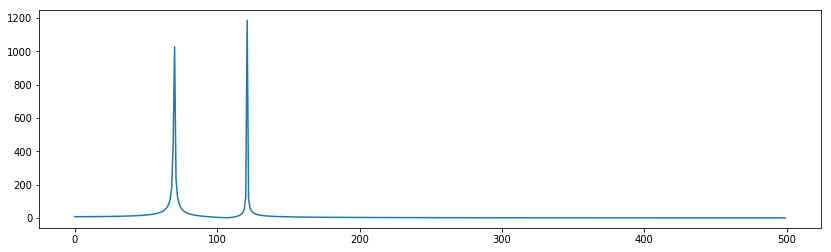

In [15]:
X = abs(np.fft.fft(x[0:2400]))
plt.plot(X[0:500]);

We clearly have identifiable peaks. The only thing we need to pay attention to is making sure that we map real-world frequencies to the DFT plot correctly (and vice versa).

In [25]:
def dtmf_decode(x, edges = None):
    # the DTMF frequencies
    LO_FREQS = np.array([697.0, 770.0, 852.0, 941.0])
    HI_FREQS = np.array([1209.0, 1336.0, 1477.0])

    KEYS = [['1', '2', '3'], ['4', '5', '6'], ['7', '8', '9'], ['*', '0', '#']]
    
    # frequency ranges to search for low and high DTMF tones
    LO_RANGE = (680.0, 960.0)
    HI_RANGE = (1180.0, 1500.0)

    number = []
    
    # now examine each tone in turn. the freqency mapping on the DFT
    #  axis will be dependent on the length of the data vector
    if edges is None:
        edges = dtmf_split(x)
    for g in edges:
        # compute the DFT of the tone segment
        X = abs(np.fft.fft(x[g[0]:g[1]]))
        N = len(X)
        # compute the resolution in Hz of a DFT bin
        res = float(FS) / N
        
        # find the peak location within the low freq range
        a = int(LO_RANGE[0] / res)
        b = int(LO_RANGE[1] / res)
        lo = a + np.argmax(X[a:b])
        # find the peak location within the high freq range
        a = int(HI_RANGE[0] / res)
        b = int(HI_RANGE[1] / res)
        hi = a + np.argmax(X[a:b])
      
        # now match the results to the DTMF frequencies
        row = np.argmin(abs(LO_FREQS - lo * res))
        col = np.argmin(abs(HI_FREQS - hi * res))

        # and finally convert that to the pressed key
        number.append(KEYS[row][col])
    return number

In [26]:
dtmf_decode(x)

['1', '2', '3', '#', '#', '4', '5']

Yay! It works! As always, in communication systems, the receiver is much more complicated than the receiver. 

Of course this is a very simplified setup and we have glossed over a lot of practical details. For instance, in the splitting function, the thresholds are not determined dynamically and this may create problems in the presence of noise. Similarly, we just detect a frequency peak in the spectrum, but noise may make things more complicated. 

For instance, listen to the following noise-corrupted version of the original signal. Although the tones are still detectable by ear, the segmentation algorithm fails and returns a single digit.

In [18]:
noisy = x + np.random.uniform(-2, 2, len(x))

IPython.display.Audio(noisy, rate=FS)


In [29]:
we[:10]

array([ 553.05330917,  557.93111518,  586.5977607 ,  578.40324732,
        521.80205774,  572.82464521,  577.15462022,  521.89229299,
        586.872759  ,  565.49407759])

In [20]:
dtmf_decode(noisy)

['3']

If we **carefully** change the segmentation threshold, we can still decode

In [31]:
dtmf_decode(noisy, dtmf_split(noisy, th=400))

['1', '2', '3', '#', '#', '4', '5']

but if we're not careful...

In [38]:
dtmf_split(x, th=250)

[(5280, 5520),
 (6480, 6720),
 (14880, 15120),
 (15600, 15840),
 (16320, 16560),
 (19680, 19920),
 (20400, 20640),
 (21120, 21360),
 (24480, 24720),
 (25680, 25920),
 (29040, 29280),
 (29760, 30000)]

In [32]:
dtmf_decode(x, dtmf_split(x, th=250))

['2', '2', '5', '5', '5', '5', '5', '5', '4', '4', '5', '5']

The sensitivity to the segmentation threshold confirms the fact that segmentation should be performed using more sophisticated techniques, which we will see in the future.